# Core Concepts

The purpose of this guide is to explain the core concepts of *scarlet*, how they are used and how they can be extended and customized for more specialized science cases.

Other resources are:

1. Our [Quickstart Guide](0-quickstart.rst) shows a typical *scarlet* session.
2. The [API Documentation](api/scarlet.rst) describes modules and classes of the python library.
3. A more in-depth explaination of the mathematics and algorithms used by *scarlet* is in [Melchior et al. 2018](https://arxiv.org/abs/1802.10157).

## Overview

The goal of *scarlet* is to create a model of individual astrophysical sources from a collection of observations of a rectangular region of the sky. These observations can be in multiple filter bands (which we will call "channels" internally) with different PSFs, from telescopes with different resolutions, and eventually even spectroscopic instruments.
A main emphasis of *scarlet* lies in deblending overlapping sources. 
Robert Lupton points out that perfect reconstruction of a blended scene is [impossible](https://docushare.lsst.org/docushare/dsweb/Services/Document-29071), however by making a few minor assumptions *scarlet* improves on other blending algorithms by leveraging as much data as possible.

The basic assumption of *scarlet* is that sources in an astrophysical image can be thought of as a collection of `Component` instances, where each component has its own internal representation of the source properties, from which it computes its model of the sources in a 3D hyper-spectral data cube of pixels vs wavelegths.
A common model is `FactorizedComponent`, which describes the source as a `Morphology` model, which generates an image, and a `Spectrum` model, which generates the intensity in every channel.
Both can be parameteric or non-parametric.
With this ansatz, more complicated objects, like galaxies, can be thought of as a combination of multiple components (a `CombinedComponent`), where components with different spectra represent different populations of stars or other features in the host galaxy. To properly separate sources, further assumptions are required, for example that all of the flux is positive and that the spatial distribution stars and galaxies monotonically decreases from their centers.

A `Frame` contains metadata for the hyperspectral cube *scarlet* seeks to construct as well as those describing an `Observation`. The latter is the combination of a `Frame` with several data units. Each observation can have multiple channels with a different PSF in each, and they will all be internally standardized.

Into the model frame one or multiple `Component`s are inserted. Each of them can create a model of the hyperspectral data cube from its `Parameter`s. The recommended way of interacting with components is through the `source` classes.

Finally, the `Blend` class links the sources with the observations and executes the optimization algorithm. 

For the most common type of source, we assume that the hyperspectral cube can be factorized into a 1D spectrum and a 2D morphology. Mathematically, the model of the scene is then

$$\mathsf{M}= \sum_{k=1}^K \mathsf{A}_k^T \times \mathsf{S}_k = \mathsf{A}\mathsf{S}, $$

where $\mathsf{A}_k \in \mathbb{R}^C$ is the spectrum and $\mathsf{S}_k \in \mathbb{R}^N$ is the morphology of a single component in the model with $C$ channels and $N$ pixels in each channel.
We call them $\mathsf{A}$ and $\mathsf{S}$ because they, more precisely, represent the **amplitude** and the **shape** of the components.
It is important to note that this so-called matrix factorization implies that spectra and morphologies are independent, e.g. the spectrum of a component does not change over the region covered by its morphology.

The scene is fit by minimizing the log-likelihood of the model, namely minimizing

$$f(\mathsf{A},\mathsf{S}) \propto \frac{1}{2} || \mathsf{Y}-\mathsf{A}\mathsf{S} ||_2^2, $$

where $\mathsf{Y}$ is a data cube and $||.||_2$ is the element-wise $L_2$ (Frobenius) norm. There is one such term for every observation.
In detail, weights and other transformations like PSF convolutions also enter here, but as long as the noise is additive and Gaussian, the general form of a quadratic log-likelihood holds.

Because there are often strong degeneracies between model components and their parameters, we exploit two mechanisms to stabilize the inference.

* Every component parameter can specify a differentiable (log-)prior distribution.
* Every component parameter can be constrained by non-differentiable penalties.

Both options turn the inference of the maximum-likelihood estimate into a maximum a posteriori (MAP) estimate by minimizing
$$f(\mathsf{A}, \mathsf{S}) + \sum_{k=1}^K \sum_{m=1}^{M_k} g^A_{km} \left(\mathsf{A}_{km} \right) + g^S_{km} \left(\mathsf{S}_{km} \right)$$


While we optimize the log-likelihood and the log-prior by gradient descent, hard constraints are enforced through proximal operators; the curious reader will find more details in [Parikh & Boyd 2014](http://www.web.stanford.edu/~boyd/papers/pdf/prox_algs.pdf) and [Combettes & Pesquet 2011](https://link.springer.com/chapter/10.1007/978-1-4419-9569-8_10).
In short, proximal operators map an input vector to the nearest vector that satisfied the respective constraint. Many constraints/penalty functions have analytic proximal operators.
The entire optimization uses the adaptive proximal gradient method (a non-smooth generalization of the popular Adam method) from the [proxmin](https://github.com/pmelchior/proxmin) package, described in [Melchior et al. 2019](https://arxiv.org/abs/1910.10094).

The remainder of this document explains how to proceed from some observation to the model parameters of interest.

## Observation

`Observation`s are specified by some data, e.g. images in a number of bands, and their meta-data.
Observational data is assumed to be standardized, i.e. multi-band image cubes are astrometrically corrected so that pixels line up across bands, and probably sky-background subtracted (unless you want to fit the sky as another component). We recommend not to perform PSF homogenization across bands as it reduces the information content of the observations. 

We also recommend specifying *all* necessary meta-data to avoid ambiguities or improper behavior.

* `weights`: per pixel inverse variances. Masked pixels have weight 0.
* `psf`: per channel point spread functions. Either an image or a function to generate the image in the native resolution of the data. The PSFs need to be spatially aligned between bands.
* `channels`: list of channel names, e.g. `['g','r','i']` for a set of broad-band filters.
* `wcs`: `astropy` compatible WCS information to make pixel positions to world coordinates.

`Observation` can be sub-classed for special instrumental models (lower resolution, grism, etc). The key methods are `match` and `render`, which enable to map between the two different frames.

## Frame

A `Frame` describes the meta-data portion of `Observation` (minus `weights`). It encodes where the observations are located with respect to a more complete hyperspectral description of the sky, e.g. a multi-band postage stamp is a set of broad-band observations `['g','r','i']` in a small rectangular region of the sky.

***scarlet* uses multiple frames: one for each observation and one for the description of the model space.** The latter encodes the "more complete hyperspectral description of the sky" mentioned above, and it is this model space that we seek to populate with source models. The model space must be able to reach the space of observations by surjective mappings. As an example, fitting two sets of observations with different filters, PSFs, and resolutions requires that the model space covers the full set of filters and has a PSF and a pixel scale that are at least as small as the smallest observed PSF and pixel scale.

*scarlet* cannot decide for you how to choose the model frame, but there are some guidelines. In general, the model frame needs to be just "wide" enough to model any signal that you could possibly have observed. It should not be wider, otherwise you seek to constrain aspect of the model for which there is no information in the observations.

* For broadband observations, the model channels should be the unique list of all filters.
* The model PSF needs to be narrower than any observed PSF. We recommend using a Gaussian with about 1 pixel width (in units of the model pixels). It's fast to compute and prevents spatial undersampling of the model.
* The model pixel scale should be small enough that no observation is undersampled.

## Source

A source is a convenient interface to specify what should be added to a model scene. Think of it as a physical unit, such as a star (`PointSource`) or a galaxy (`ExtendedSource`). It is a subclass of `Component` with a recipe to initialize and constrain its `Parameters`:

In [1]:
import scarlet
import inspect
lines = inspect.getsource(scarlet.PointSource)
print(lines)

class PointSource(FactorizedComponent):
    """Point-Source model

    Point sources modeled as `model_frame.psfs`, centered at `sky_coord`.
    Their SEDs are taken from `observations` at the center pixel.
    """

    def __init__(self, model_frame, sky_coord, observations):
        """Source intialized with a single pixel

        Parameters
        ----------
        model_frame: `~scarlet.Frame`
            The frame of the model
        sky_coord: tuple
            Center of the source
        observations: instance or list of `~scarlet.Observation`
            Observation(s) to initialize this source
        """
        if not hasattr(observations, "__iter__"):
            observations = (observations,)

        center = model_frame.get_pixel(sky_coord)
        morphology = PointSourceMorphology(model_frame, center)

        # get spectrum from peak pixel, correct for PSF
        spectra = init.get_pixel_spectrum(sky_coord, observations, correct_psf=True)
        spectrum = np.c

This is a simple but prototypical implementation. The base class is `FactorizedComponent`, which uses the Spectrum-Morphology factorization introduced earlier. Therefore, it needs to define these two so that the fitter will know to optimize them. 

The initialization can make use of an observation to find suitable initial values of the `spectrum` parameter. As good initialization usually leads to much better results, this is where you should use your own insight to come up with guesses and step sizes that are suitable for the problem. This is the reason why ***scarlet* implements `source` classes as the primary interface to create custom solutions** for special analysis problems. It is layered on top of `Component`, which is derived from the generic `Model` classes, to make customization easier.

## Blend

The central piece of *scarlet* is the `Blend` class. It connects the list of sources to the list of observations and provides the `fit` method, which adjusts the parameters of the sources to match the observations. The result is a MAP solution that maximizes the log-likelihood under specified priors and constraints, as well as an error estimate for every parameter.

## Component

`Component` is the base class for all objects that populate the model space. It generates a hyperspectral model for a list of parameters.

These model parameterizations are available:

* `CubeComponent` is the simplest model. It specifies a free-form (often incorrectly called "non-parametric") description of the hyperspectral frame, or a subvolume of it. Every voxel is independent.
* `FactorizedModel` uses the Spectrum-Morphology factorization. Both of these can be free-form or described by some functional form. They are specified by a `Spectrum` and a `Morphology` factor, which generate a model of the spectrum or morphology from its parameters.

Most of these models can be restricted to subvolumes by specifying a bounding `Box`. Alternative parameterizations are entirely doable. Open an [issue](https://github.com/pmelchior/scarlet/issues) if you need help with that.

## Parameter

Every component can declare its own parameters, which we can access by with the `parameters` property. To demonstrate, we load the sources from the [Quick Start Guide](0-quickstart.rst):

In [2]:
import pickle

fp = open("hsc_cosmos_35.sca", "rb")
sources = pickle.load(fp)
fp.close()

for k,src in enumerate(sources):
    print ("Source {}: {}".format(k, src.__class__.__name__))
    for p in src.parameters:
        print ("  Parameter '{}', Shape {}".format(p.name, p.shape))

Source 0: PointSource
  Parameter 'spectrum', Shape (5,)
  Parameter 'center', Shape (2,)
Source 1: MultiExtendedSource
  Parameter 'spectrum', Shape (5,)
  Parameter 'image', Shape (31, 31)
  Parameter 'shift', Shape (2,)
  Parameter 'spectrum', Shape (5,)
  Parameter 'image', Shape (61, 61)
  Parameter 'shift', Shape (2,)
Source 2: MultiExtendedSource
  Parameter 'spectrum', Shape (5,)
  Parameter 'image', Shape (41, 41)
  Parameter 'shift', Shape (2,)
  Parameter 'spectrum', Shape (5,)
  Parameter 'image', Shape (41, 41)
  Parameter 'shift', Shape (2,)
Source 3: SingleExtendedSource
  Parameter 'spectrum', Shape (5,)
  Parameter 'image', Shape (31, 31)
  Parameter 'shift', Shape (2,)
Source 4: CompactExtendedSource
  Parameter 'spectrum', Shape (5,)
  Parameter 'image', Shape (21, 21)
  Parameter 'shift', Shape (2,)
Source 5: SingleExtendedSource
  Parameter 'spectrum', Shape (5,)
  Parameter 'image', Shape (31, 31)
  Parameter 'shift', Shape (2,)
Source 6: CompactExtendedSource
  P

Source 0 is a `PointSource`, parameterized by a spectrum and a center, as we have seen above. Source 1 has multiple components (each with a spectrum and an image morphology), others have a single spectrum and image morphology.

`Parameter` is a souped up `numpy` array. It has a value and a name, as well as additonal attributes that store a `prior` and `constraint` that were enforced during optimization; the typical `step` size during optimization; an estimate of the standard deviate `std`; and whether the parameter was held `fixed`:

In [3]:
sources[0].parameters[0].__dict__

{'name': 'spectrum',
 'prior': None,
 'constraint': <scarlet.constraint.PositivityConstraint at 0x7f5ec82085e0>,
 'step': functools.partial(<function relative_step at 0x7f5ecd3f4040>, factor=0.01, minimum=array([0.01279404, 0.01422727, 0.02035177, 0.03339863, 0.06668474])),
 'std': masked_array(data=[0.02782697011630998, 0.015044047532164796,
                    0.027118815493023137, 0.05929413054496282,
                    0.2224104597472498],
              mask=[False, False, False, False, False],
        fill_value=0.0),
 'm': array([-1.85283971, -1.21397917, -1.95521605,  0.89712297, -0.46790913]),
 'v': array([1291.42192922, 4418.45672858, 1359.74843418,  284.43077825,
          20.21573725]),
 'vhat': array([1306.86802229, 4494.58960342, 1386.84907222,  290.76902234,
          20.67936066]),
 'fixed': False}

In our example, several parameters have converged within relative changes of `e_rel=1e-3` (the default setting of `Blend.fit`), but others have not. The fitter will have complained about non-convergence...

To demonstrate the use of the error estimate, we make a signal-to-noise map of the morphology of source 5:

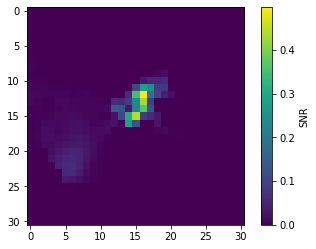

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

p = sources[5].parameters[1]
plt.imshow(p / p.std)

plt.colorbar(label='SNR')

The SNR map shows that the center region is well determined by the data. Note that this error estimate is purely statistical and does not include correlations between different parameters or different components.

## Step Size

**For every parameter, *you* have to specify to typical size of steps the optimizer should take.** Picking small steps leads to slow convergence, while large step sizes may lead to no convergence at all!

*scarlet* uses the `adaprox` method from `proxmin`, which expects step sizes to be set in units of the parameter. That makes them relatively transparent. For instance, if you want to optimize the center position and you expect it to be initialized within 1 pixel of its optimal position, a step size of 0.1 is reasonable. Often, relative steps sizes are effective if one does not know the absolute magnitude of the parameter beforehand. We offer the method `scarlet.relative_step` specifically for this purpose. Inspecting the parameter above, you can see that it in fact used this method, with a relative factor of 0.01, i.e. the fitting method makes steps that are 1% of the mean magnitude of the parameter.

The step size can either be an ordinary number, or a function with the signature `step(X, it) -> float`, where `X` is the parameter itself, and the second argument is the iteration counter of the optimizer. It is possible to specify a step size *per element* of a parameter. Proceed at your own peril.

## Prior

`Prior` and `Constraint` bring in additional information, which helps with robust parameter inference, which is especially important for cases with strong parameter degeneracies. Blending inevitably yields such degeneracies.

`Prior`s encode which values for a parameter are more likely. The optimimization adds the log-likelihood and the log-prior to find a MAP estimate.

`Prior`s need to implement two methods:

* `__call__(self, x)` returns the logarithm of the prior at the value `x` of the parameter
* `grad(self, x)` returns the gradient of the logarithm of the prior at `x`.

## Constraint

`Constraint`s appear similar to `Prior`s, in that they describe prior information about valid parameter values. However, they differ in profound ways. A wide class of constraints are projections onto submanifolds of the parameter space, typically guided by theoretical knowledge or assumptions. Examples are the subspace of positive elements or the surface of a sphere. This means that solutions outside of the manifold are forbidden, while all solution on the manifold are equally acceptable. The transition between these two cases is generally non-differentiable. This requires a generalization of gradient-based optimizers to so-called sub-gradients, and the employment of proximal operators.

`Constraint`s need to implement only one method: `__call__(self, x, step)` which returns the result of the proximal mapping for a parameter with value `x`. For projection operators, that amounts to the point on the desired manifold that is closest to `x` in the Euclidean metric. The argument `step` is the step size for the current gradient step, which is only used for some classes for proximal operators. Conveniently, projection operators *don't* use it.

*scarlet* implements several proximal constraints, some of which we discuss below. In addition, L1 and L0 sparsity penalties are implemented. More can be added by exploiting analytical results e.g. in [Parikh & Boyd 2014](http://www.web.stanford.edu/~boyd/papers/pdf/prox_algs.pdf) and [Combettes & Pesquet 2011](https://link.springer.com/chapter/10.1007/978-1-4419-9569-8_10). Open an [issue](https://github.com/pmelchior/scarlet/issues) for help.

### Positivity

`PositivityConstraint` avoids the negative subspace. It performs the mapping $x\rightarrow \max(0, x)$ on every element of a parameter.

### Normalization


For `FactorizedComponent`, a fundamental degeneracy arises from the question which of the factors should capture the amplitude of the model. The overall flux could be stored in the spectrum or in the morphology, or some combination of both. The last option is degenerate.

`NormalizationConstraint` allows to normalize the parameter, either to the sum of all elements or to the maximum element. In *scarlet*, we usually normalized the component morphology with `type='max'`, which can be very easily initialized without regarding the extent of the source. It results in the spectrum encoding color and intensity information. The advantage of this normalization is that two sources with similar colors can still be distinguished if they have different intensities.

### Symmetry

Many traditional models for fitting galaxies (Sersic, mixture-of-Gaussian, ...) implicitly employ this constraint, because most galaxies are in fact *largely* symmetric. For free-form models, demanding that astrophysical sources are symmetric reduces the number of effective degrees of freedom of the model by half. Using symmetry as a constraint has been used successfully in the SDSS deblender and also in our tests on substantially deeper HSC images. The proximal mapping for every symmetric pair of pixels $i,j$ is $x_i,x_j\rightarrow\tfrac{1}{2}(x_i + x_j)$.

To make a source symmetric requires a position to make the model symmetric about. Source models are highly sensitive to this fractional pixel location so it is necessary to include an update function that estimates the position of a symmetric source in the blend. This operation is expensive, so the stability of this constraint needs to be weighed against the cost of enforcing it.

### Monotonicity

Another useful constraint from the SDSS-HSC deblender is the assumption that most astrophysical objects are monotonically decreasing from the peak.
In detail, this assumption is incorrect e.g. for spiral galaxies, especially tightly wound ones.
But we can build good representations of even complex galaxies as multiple stellar populations, each with a single spectrum and monotonically decreasing from its peak.

We implemented three possible monotonic solutions in `MonotonicityConstraint`. Each of them restrict the intensity of the active pixel $i$ (blue) to at most the average of the pixel intensity of its direct neighbors in the direction of the source center (ochre):

$$
x_i\leq\frac{1}{N_i}\sum_j^{N_i} w_j x_j
$$

| ![](images/nearest_ref.png) | ![](images/weighted_ref.png) |
|:---------------------------:|:----------------------------:|
| Nearest Neighbor            | Weighted Reference           |

* `neighbor_weight='nearest'`: Only the neighbor that is closest to the center  defines the reference. This mode is the most flexible one but prone to creating radial "spikes".
* `neighbor_weight='angle'`: All three neighbor pixels that are closer to the peak are combined to compute the reference intensity. The weights of the neighbor $w_j = \cos(\alpha_i - \alpha_j)$, where $\alpha_i$ and $\alpha_j$ are the angles from the active and the neighbor pixel to the center, respectively. This option is a softened version of the nearest-neighbor weight but still prefers strong radial monotonicity and thus similarly prone to radial spikes.
* `neighbor_weight='flat'`: All three neighbor pixels that are closer to the peak are combined with flat weights to compute the reference intensity. This option is the most restrictive and allows for the greatest degree of azimuthal smoothing.

The monotonicity mapping hinges on a properly centered source, but in contrast to symmetry the center has to be localized only within one pixel.

#### Implementation Note

`MonotonicityConstraint` is implemented as a projection that is *not* a true proximal operator. It is possible to write monotonicity as a true proximal operator, but the implementation is far too slow for practical purposes. Instead, the morphology is projected into a space that has *a* monotonic solution, just not necessarily the closest one in the L2 sense.

### Constraint Chains

If multiple constraints should be simultaneously enforced, they can be organized in a `ConstraintChain`. We make use of the method of [Alternating Projections](https://en.wikipedia.org/wiki/Projections_onto_convex_sets), which finds a solution in the intersection of multiple submanifolds by sequentially projecting on every manifold. Normally, this process needs to be repeated multiple times to ensure that all constraints are being met. In practice, it is sufficient to repeat this process only once because the optimizer will require multiple iterations to finally converge, so in the vicinity of the final solution, multiple projections are in fact performed.